In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from random import choice,shuffle
from scipy import stats as st

from collections import deque

In [7]:
def gather_data(num_samples):

    global rock, paper, scissor, nothing
    
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    trigger = False
    counter = 0
    box_size = 234
    width = int(cap.get(3))

    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)

        if not ret:
            break

        if counter == num_samples:
            trigger = not trigger
            counter = 0
        
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        cv2.namedWindow("Collecting Images", cv2.WINDOW_NORMAL)

        if trigger:
            roi = frame[5: box_size-5, width-box_size+5: width-5]
            eval(class_name).append([roi, class_name])
            counter += 1
            text = "Collected samples of {}: {}".format(class_name, counter)

        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"

        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.imshow("Collecting images", frame)

        k = cv2.waitKey(1)
        if k == ord('r'):
            trigger = not trigger
            class_name = 'rock'
            rock = []

        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []

        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []

        if k == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [8]:
no_of_samples = 100
gather_data(no_of_samples)

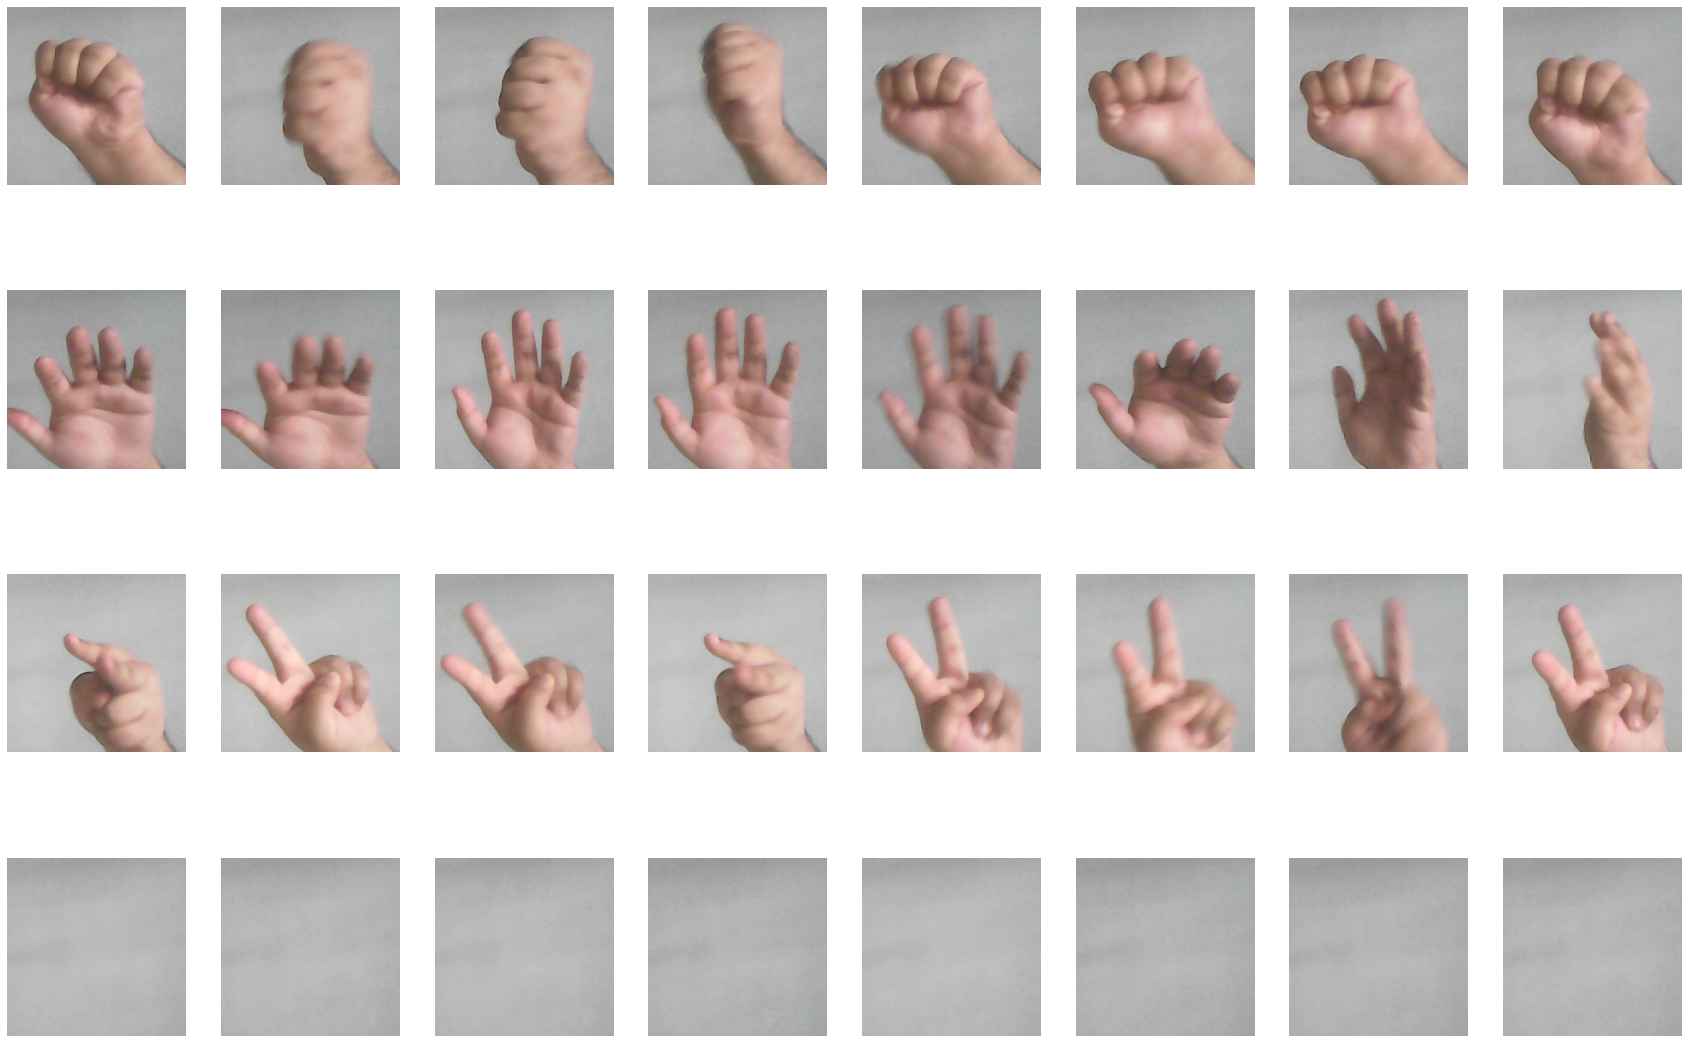

In [11]:
plt.figure(figsize=[30,20])
rows, cols = 4, 8
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
    r = np.random.randint(no_of_samples, size=8);
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');

In [13]:
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] + [tupl[1] for tupl in nothing]
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] + [tupl[0] for tupl in nothing]
images = np.array(images, dtype="float") / 255.0
print('Total images: {} ,Total labels: {}'.format(len(labels), len(images)))
encoder = LabelEncoder()
Int_labels = encoder.fit_transform(labels)
one_hot_labels = to_categorical(Int_labels, 4)
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size = 0.25, random_state = 50)
images = []

Total images: 400 ,Total labels: 400


In [16]:
image_size = 224
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
N_mobile.trainable = False
x = N_mobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(712, activation='relu')(x) 
x = Dropout(0.40)(x)
preds = Dense(4,activation='softmax')(x) 
model = Model(inputs=N_mobile.input, outputs=preds)
print ("Number of Layers in Model: {}".format(len(model.layers[:])))

Number of Layers in Model: 773


In [17]:
augment = ImageDataGenerator(
    rotation_range = 30,
    zoom_range = 0.25,
    width_shift_range = 0.10,
    height_shift_range = 0.10,
    shear_range = 0.10,
    horizontal_flip = False,
    fill_mode = "nearest"
)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
epochs = 15
batchsize = 10

history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
                   steps_per_epoch=len(trainX) // batchsize, epochs=epochs)

Epoch 1/15
30/30 [==============================] - 62s 1s/step - loss: 0.8445 - accuracy: 0.7433 - val_loss: 0.4194 - val_accuracy: 0.9300
Epoch 2/15
30/30 [==============================] - 25s 840ms/step - loss: 0.3832 - accuracy: 0.9067 - val_loss: 0.2185 - val_accuracy: 0.9500
Epoch 3/15
30/30 [==============================] - 26s 865ms/step - loss: 0.2114 - accuracy: 0.9667 - val_loss: 0.1466 - val_accuracy: 0.9600
Epoch 4/15
30/30 [==============================] - 26s 885ms/step - loss: 0.1664 - accuracy: 0.9633 - val_loss: 0.1371 - val_accuracy: 0.9600
Epoch 5/15
30/30 [==============================] - 27s 914ms/step - loss: 0.1228 - accuracy: 0.9767 - val_loss: 0.0937 - val_accuracy: 0.9600
Epoch 6/15
30/30 [==============================] - 28s 940ms/step - loss: 0.1035 - accuracy: 0.9867 - val_loss: 0.0766 - val_accuracy: 0.9800
Epoch 7/15
30/30 [==============================] - 23s 757ms/step - loss: 0.0944 - accuracy: 0.9767 - val_loss: 0.0699 - val_accuracy: 0.9800
Ep

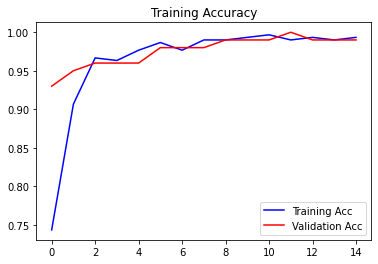

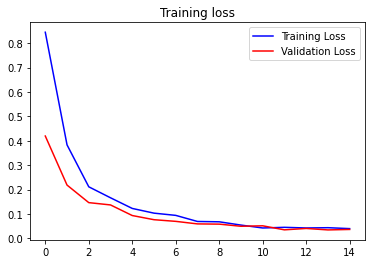

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [23]:
model.save("rps4.h5", overwrite=True)


In [2]:
model = load_model("rps4.h5")

In [25]:
label_names = ['nothing', 'paper', 'rock', 'scissor']
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
box_size = 234
width = int(cap.get(3))
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
    cv2.namedWindow("Rock Paper Scissor", cv2.WINDOW_NORMAL)
    roi = frame[5: box_size-5 , width-box_size +5: width - 5]
    roi = np.array([roi]).astype('float64') / 255.0
    pred = model.predict(roi)
    target_index = np.argmax(pred[0])
    prob = np.max(pred[0])
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100),
               (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow("Rock Paper Scissor", frame)
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [3]:
def play(user, computer):
    if user == computer:
        return "Tie"
    elif user == "rock" and computer == "scissor":
        return "User"
    elif user == "rock" and computer == "paper":
        return "Computer"
    elif user == "scissor" and computer == "paper":
        return "User"
    elif user == "scissor" and computer == "rock":
        return "Computer"
    elif user == "paper" and computer == "rock":
        return "User"
    elif user == "paper" and computer == "scissor":
        return "Computer"

In [4]:
user = 'rock'
computer = choice(['rock', 'paper', 'scissor'])

winner = play(user, computer)
print("User selected '{}' and computer selected '{}', winner is: '{}' ".format(user, computer, winner))

User selected 'rock' and computer selected 'scissor', winner is: 'User' 


In [5]:
def show_winner(user_score, computer_score):
    if user_score > computer_score:
        img = cv2.imread("images/youwin.jpg")
    elif user_score < computer_score:
        img = cv2.imread("images/comwins.jpg")
    else:
        img = cv2.imread("images/draw.jpg")
    cv2.putText(img , "Press 'Enter' to play again, else exit",
               (150, 530), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
    cv2.imshow("Rock Paper Scissor", img)
    
    k = cv2.waitKey(0)
    if k == 13:
        return True
    else:
        return False

In [6]:
def display_computer_move(computer_move_name, frame):
    icon = cv2.imread("images/{}.png".format(computer_move_name), 1)
    icon = cv2.resize(icon, (224, 224))
    roi = frame[0:224, 0:224]
    mask = icon[:,:,-1]
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
    icon_bgr = icon[:,:,:3]
    
    img1_bg = cv2.bitwise_and(roi, roi, mask=cv2.bitwise_not(mask))
    img2_bg = cv2.bitwise_and(icon_bgr, icon_bgr, mask=mask)
    combined = cv2.add(img1_bg, img2_bg)
    frame[0:224, 0:224] = combined
    return frame

In [ ]:
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))
attempts = 5
computer_move_name= "nothing"
final_user_move = "nothing"
label_names = ['nothing', 'paper', 'rock', 'scissor']
computer_score, user_score = 0, 0
rect_color = (255, 0, 0)
hand_inside = False
total_attempts = attempts
confidence_threshold = 0.70
smooth_factor = 5
de = deque(['nothing'] * 5, maxlen=smooth_factor)

while True:    
    ret, frame = cap.read()
    if not ret:
        break    
    frame = cv2.flip(frame, 1)      
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    roi = np.array([roi]).astype('float64') / 255.0
    pred = model.predict(roi)
    move_code = np.argmax(pred[0])
    user_move = label_names[move_code]
    prob = np.max(pred[0])
    if prob >= confidence_threshold:
        de.appendleft(user_move)
        try:
            final_user_move = st.mode(de)[0][0]   
        except StatisticsError:
            print('Stats error')
            continue
        if final_user_move != "nothing" and hand_inside == False:
            hand_inside = True 
            computer_move_name = choice(['rock', 'paper', 'scissor'])
            winner = findout_winner(final_user_move, computer_move_name)
            display_computer_move(computer_move_name, frame)
            total_attempts -= 1
            if winner == "Computer":
                computer_score +=1
                rect_color = (0, 0, 255)

            elif winner == "User":
                user_score += 1;
                rect_color = (0, 250, 0)
                
            
            elif winner == "Tie":
                rect_color = (255, 250, 255)
   
            if total_attempts == 0:
                play_again = show_winner(user_score, computer_score)
                if play_again:
                    user_score, computer_score, total_attempts = 0, 0, attempts
                else:
                    break
        
        
        elif final_user_move != "nothing" and hand_inside == True:
            display_computer_move(computer_move_name, frame)
    
        
        elif final_user_move == 'nothing':            
            hand_inside = False
            rect_color = (255, 0, 0)
 


    cv2.putText(frame, "Your Move: " + final_user_move,
                    (420, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    cv2.putText(frame, "Computer's Move: " + computer_move_name,
                (2, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    cv2.putText(frame, "Your Score: " + str(user_score),
                    (420, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Computer Score: " + str(computer_score),
                    (2, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    
    cv2.putText(frame, "Attempts left: {}".format(total_attempts), (190, 400), cv2.FONT_HERSHEY_COMPLEX, 0.7,
                (100, 2, 255), 1, cv2.LINE_AA)
    
    
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), rect_color, 2)
    cv2.imshow("Rock Paper Scissors", frame)
    k = cv2.waitKey(10)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()